### Workflow to Validate NISAR L2Permafrost Displacement Requirement

**Code authored by:** Andrew Johnson, Simon Zwieback, Franz Meyer, Jie Chen</br>
2024

<div class="alert alert-warning">
UPDATE THIS Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

Define CalVal Site

NOTE: This section to be removed very soon when permafrost metadata is in the calval database. Data will be pulled from there instead.

In [52]:
# Choose a site and track direction
# Available permafrost displacement validation sites: 
#        NorthSlopeEastD102      : North Slope of Alaska including Dalton highway, Sentinel-1 path (track) 102. The
#                                  field validation sites are located in this frame.

site = 'NorthSlopeEastD102'
requirement = 'permafrost'
dataset = 'Hyp3_S1'
year = 2025
start_directory = 'default'
sitedata =  {'calval_location' : 'NorthSlopeEastD102',
            'region_identifier' : 'POINT(-149.37 69.09)',
            'subset_region' : '[7624680:7696680,598120:670120]',            
            'download_start_date' : '20230525',
            'download_end_date'   : '20230910',
            'mintpy_ref_loc'      : '7651392, 666923',
            'tempBaseMax' : '36',
            'ifgExcludeList' : 'auto',
            'maskWater' : 'True',
            'sentinel_direction' : 'DESCENDING',
            'sentinel_path' : '102',
            'sentinel_frame' : '362'}

### Table of Contents


[**Prep A. Environment Setup**](#permafrost_prep_a)

[**Prep B. Data Staging**](#permafrost_prep_b)

[**1. Generation of Interferogram stack**](#permafrost_infgs)

[**2. Generation of time series from interferograms**](#permafrost_mintpy)
- [2.1 Set up MintPy configuration file](#permafrost_mintpy_config)
- [2.2 Load data into MintPy](#permafrost_mintpy_load)
- [2.3 Validate/Modify interferogram network](#permafrost_mintpy_validate)
- [2.4 Reference interferograms to common lat/lon](#permafrost_mintpy_reference)
- [2.5 Invert for SBAS line-of-site timeseries](#permafrost_mintpy_invert)

[**3. Optional Corrections**](#permafrost_correct)
- [3.1 Troposphere correction](#permafrost_corect_troposphere)
- [3.2 Phase deramping](#permafrost_correct_phase)
- [3.3 Topographic residual correction](#permafrost_correct_topography)

[**4. Validation method A: InSAR-only struction functions**](#permafrost_insar_validate)
- [4.1 Use structure functions to identify pixel pairs](#permafrost_insar_structure)
- [4.2 Evaluate displacements of pairs with respect to requirement](#permafrost_insar_evaluate)

[**5. Validation method B: Comparison to ground truth displacements**](#permafrost_field_validate)
- [5.1 Load field data](#permafrost_field_data)
- [5.2 Prepare InSAR for field comparison](#permafrost_field_prepare)
- [5.3 Re-run MintPy with field reference points](#permafrost_reference_point)
- [5.4 Evaluate displacements with respect to requirement](#permafrost_field_evaluate)

<hr/>
<a id='permaforst_prep_a'></a>

### Environment Setup

#### Load Python Packages

In [82]:
import numpy as np
import pandas as pd
import os
import subprocess
import h5py

from datetime import datetime as dt
from matplotlib import pyplot as plt
from pathlib import Path
from mintpy import plot_network,view
from mintpy.utils import readfile
from solid_utils import permafrost_utils as pu
from solid_utils.sampling import load_geo_utm, samp_pair,load_geo_utm
from solid_utils.plotting import display_permafrost_validation, display_validation_table,display_transient_validation
from solid_utils.saving import save_results

In [54]:
################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

# if 'start_directory' not in locals():
#     start_directory = 'default'    
# if start_directory == 'default':
start_directory = Path(f'/scratch/nisar-st-calval-solidearth/permafrost')
# if 'work_dir' not in locals():
work_dir = os.path.join(start_directory,dataset,site,str(year))
# if 'field_dir' not in locals():
field_dir = os.path.join(start_directory,'fielddata')

gunw_dir = os.path.join(work_dir,'products')
mintpy_dir = os.path.join(work_dir,'MintPy')
os.makedirs(mintpy_dir,exist_ok=True)
print("   MintPy  dir:", mintpy_dir)

# # Change to Workdir   
os.chdir(mintpy_dir)


Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2024/MintPy
   MintPy  dir: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy


<a id='permafrost_prep_b'></a>
## Prep B: Data staging

Author's note: processed Sentinel-1 interferograms may be staged in a S3 bucket in the future. They are not staged yet however, so ```Use_Staged_Data``` must remain false, and the interferograms must be obtained from Hyp3. 

See [Section 1](#permafrost_infgs) for details on creating and downloading this data.

In [45]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

######### DO NOT CHANGE LINES BELOW ########

if Use_Staged_Data:
    #No data included in staging yet.
    print('This section has yet to be added.\nNo data has been staged yet.')
else:
    #Data must be processed from Hyp3
    print('Not using staged data. You must use Hyp3 to produce the interferograms.')
    print('Field validation data is currently included in the git repo at the moment,\nbut will be moved to the cal/val database')

Not using staged data. You must use Hyp3 to produce the interferograms.
Field validation data is currently included in the git repo at the moment,
but will be moved to the cal/val database


<a id='permafrost_infgs'></a>
# 1. Generation of interferogram stack

The NISAR project will provide sets of fully coregistered ascending and descending unwrapped L2 interferograms (aka InSAR “stacks”) over regions of interest listed in the NISAR Solid Earth calval document. Prior to the launch of NISAR, we use interferograms generated by the Hybrid Pluggable Processing Pipeline (Hyp3) at the Alaska Satellite Facility (ASF) from Sentinel-1 SAR data. Hyp3 interfergram generation uses GAMMA and identifies overlapping Sentinel-1 bursts, and coregisters them using an iterative offset polynomial method and an Enhanced Spectral Diversity algorithm. Information about the Hyp3 inferferogram generation [can be found here](#https://hyp3-docs.asf.alaska.edu/guides/insar_product_guide/).

Use the [Generating Hyp3 Interferograms](./Generate_Hyp3_Interferograms.ipynb) notebook to produce and download this data. We create interferogram stacks to cover a 96 day summer time period over on permafrost terrain to measure displacement when the surface is snow-free and traditionally experiencing subsidence.

<a id='permafrost_mintpy'></a>
# 2. Generation of time series from interferograms

InSAR time series (i.e. the unfiltered displacement of each pixel vs. time) will be estimated from a processed InSAR stack using a variant of the small baseline subset (SBAS) approach. For this step, we use a time series inversion method of the Miami InSAR Time-series software in Python (MintPy) with 12 and 24 day interferogram pairs.

Note: this code is currently set up to run on MintPy version 1.5.1.

In [55]:
# Loading data into mintpy, if not done already
config_file = os.path.join(mintpy_dir,site + f'_{year}.cfg')
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep load_data'
process = subprocess.run(command, shell=True)

/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


MintPy version 1.6.0, date 2024-05-09
--RUN-at-2025-09-29 19:52:24.318485--
Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2025
Go to work directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy/NorthSlopeEastD102_2025.cfg
update default template based on input custom template
    mintpy.subset.lalo: no --> [7620213:7686754,

In [ ]:
#we're looking to builk up

<a id='permafrost_mintpy_validate'></a>
## 2.1 Validate/Modify Interferogram Network


In [56]:
config_file = os.path.join(mintpy_dir,site + f'_{year}.cfg')
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

MintPy version 1.6.0, date 2024-05-09
--RUN-at-2025-09-29 19:52:37.136645--
Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2025
Go to work directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy/NorthSlopeEastD102_2025.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-ca

<a id='permafrost_mintpy_reference'></a>
## 2.2 Reference interferograms to common Lat/Lon

Note: The printed ```REF_LAT``` and ```REF_LON``` from this step will be the UTM y and x coordinates, respectively. ```REF_X``` and ```REF_Y``` are the j and i (column and row) indices of the reference.

In [57]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

  REF_LAT                      7651360.0
  REF_LON                      666960.0
  REF_X                        313
  REF_Y                        442


<a id='permafrost_mintpy_invert'></a>
## 2.3 Invert for SBAS Line-of-Sight Timeseries

Run the network inversion to generate the timeseries file.

Note: If run in OpenScienceLab, this step takes approximately 30 minutes to complete.

In [58]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version 1.6.0, date 2024-05-09
--RUN-at-2025-09-29 19:52:48.951192--
Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2025
Go to work directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy/NorthSlopeEastD102_2025.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2025/MintPy/smallbaseline

<a id='permafrost_correct'></a>
# 3. Optional corrections

Mintpy provides functionality for a number of standard corrections which might improve the accuracy of the timeseries inversion or displacement results. Several corrections are shown here:

* Troposphere correction </br>
* Deramping </br>
* Topographic residual correction

None of these corrections are currently applied in the analysis presented in this notebook, but the code here can easily be modified to add this functionality if desired.

<a id='permafrost_correct_troposphere'></a>
## 3.1 Trophosphere correction

Atmospheric effects, especially moisture, can cause phase delays in the measured satellite signal. ERA5 reanalysis products provide information about atmospheric moisture and can be used to estimate the tropospheric phase delays. Performing this correction requires obtaining the ERA5 reanalysis products separately.

In [11]:
do_tropo_correction = False
########################################################################
'''
REFERENCE : https://github.com/insarlab/pyaps#2-account-setup-for-era5
Read Section 2 for ERA5 [link above] to create an account on the CDS website.
'''

if do_tropo_correction:
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    # view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

<a id='permafrost_correct_phase'></a>
## 3.2 Phase deramping
\[Mintpy provides this functionality]

In [8]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version 1.6.0, date 2024-05-09
--RUN-at-2025-09-29 18:01:01.835012--
Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/No

<a id='permafrost_correct_topography'></a>
## 3.3 Topographic residual correction
\[Mintpy provides this functionality\]

In [9]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version 1.6.0, date 2024-05-09
--RUN-at-2025-09-29 18:01:07.598751--
Current directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEa

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/solid_earth_atbd/bin/smallbaselineApp.py", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/mintpy/cli/smallbaselineApp.py", line 209, in main
    run_smallbaselineApp(inps)
  File "/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/mintpy/smallbaselineApp.py", line 1155, in run_smallbaselineApp
    app.run(steps=inps.runSteps)
  File "/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/mintpy/smallbaselineApp.py", line 941, in run
    self.run_topographic_residual_correction(sname)
  File "/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/mintpy/smallbaselineApp.py", line 729, in run_topographic_residual_correction
    mintpy.cli.dem_error.main(iargs)
  File "/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/mintpy/cli/dem_error.py", line 178, in m

<!-- <a id='permafrost_insar_validate'></a>
# 4. Validation Method 1: Comparison to observed field data

The NISAR permafrost validation requirement states that at least 80% of the time, the difference in surface displacement for two given points over 90 days should be no greater than $4(1+\sqrt{\text{L}})$ mm for points of L km apart, with $\text{L} \leq 50$ km.
 -->

<a id='permafrost_field_validate'></a>
# 4. Validation Method 1: Comparison to ground truth displacements



<!-- We can compare the Interferometric displacements to the measured displacements at the field sites. The locations of the field sites are as follows (XY values in UTM, EPSG 32605):

Happy Valley (HV): x=664946, y=7677215</br>
Happy Valley East (HVE): x=665175, y=7677290</br>
Ice Cut (IC): x=666290, y=7664601</br>
Slope Mountain (SM): x=664156, y=7629999</br> -->

In [59]:
pointnames = ['HV','HVE','IC','SM']
pointlocs = [[1114,3285],[1113,3288],[1272,3302],[1705,3275]]
pointlocsxy = [[664946,7677215],[665175,7677290],[666290,7664601],[664156,7629999]]
pointsubsetlocs = [[119, 287], [118, 290], [277, 304], [710, 277]]

<a id='permafrost_field_data'></a>
## 4.1 Load field data

Field observations of summer subsidence were taken for several areas of interest on the North Slope of Alaska, along the Dalton Highway. The ground in this area is snow-free for approximately three months each summer, usually from late May to late August. Measurements from leveling (surveying) and GNSS were taken at the beginning and end of this summer time period. Each field area of interest has 153 sampled points over a 100 m square on the ground.

The end result of these observations are direct measurements of the surface subsidence which can be compared with the satellite-InSAR derived surface displacement product. See the accompanying notebook [Permafrost_fielddata](./Permafrost_fielddata.ipynb) for details. That notebook produces a small file called ```field_results.csv```, which is an input for this validation.

We create an array for the relative displacement of each field site relative to each other site.

In [28]:
work_dir

'/scratch/nisar-st-calval-solidearth/permafrost/Hyp3_S1/NorthSlopeEastD102/2023'

In [60]:
#Load in observed data
fielddata_file = Path(work_dir)/'field_results.csv'

obsdata = pd.read_csv(fielddata_file) #ground truth observations
obsdisp = obsdata['rel_change'][:]
obsstd = obsdata['stdev'][:]
obsdiff = np.zeros((len(obsdisp),len(obsdisp)))
obsdiffstd = np.zeros_like(obsdiff)
fielddates = []
for i in range(len(obsdisp)):
    for j in range(len(obsdisp)):
        obsdiff[i,j] = obsdisp[i]-obsdisp[j]

        #use sum of squares to propagate error of subtracted measurements
        obsdiffstd[i,j] = np.sqrt(obsstd[i]**2+obsstd[j]**2)
    
    date1 = dt.strptime(str(obsdata['date1'][i]),'%Y-%m-%d')
    date2 = dt.strptime(str(obsdata['date2'][i]),'%Y-%m-%d')
    fielddates.append([date1,date2])

In [61]:
obsdisp

0   -0.034877
1   -0.020582
2   -0.038640
3   -0.009863
Name: rel_change, dtype: float64

<a id='permafrost_field_prepare'></a>
## 4.2 Prepare InSAR for field comparison


In order to perform double differencing of InSAR displacements in a way that will be comparable to the field observations, we run the mintpy inversion several times, with the reference point set to a different field validation site each time, and also using a spline fitting function to fit the InSAR timeseries to the exact dates of the field measurements.


**Time series reconstruction**

The displacement time series from mintpy is reconstruted here by spline-fitting it the time series to a set of basis functions, following Zwieback et al. (2020). The basis functions represent typical summer permafrost surface subsidence patterns, due melting ice in the active layer. The spline fitting reconstruction both reduces the noise from individual acquisitions, and also allows us to identify the InSAR displacement for arbitrary dates within the period.


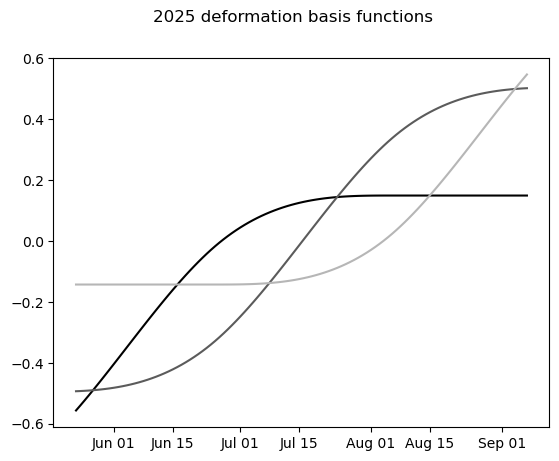

In [62]:
ts = pu.Timeseries.from_file(fn = Path(mintpy_dir)/timeseries_filename)
sm = pu.SplineModel(dates_o=ts.dates)

#perform the reconstruction
ts_rec = sm.reconstruct(timeseries=ts)

# plot basis functions
pu.plot_basis_functions(sm)

Now we will demonstrate the reconstuction at a single point.

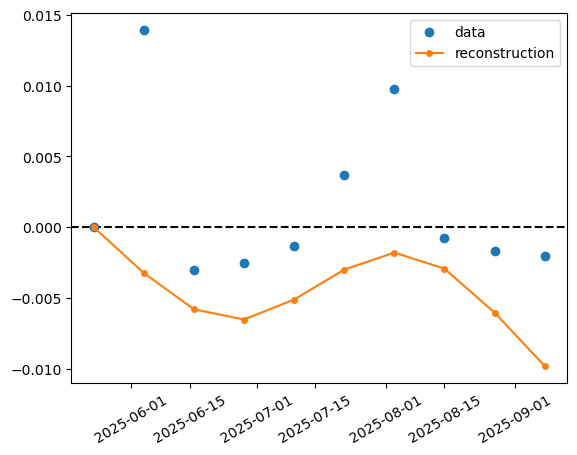

In [63]:
ipt,jpt = 500,200

plt.figure()
plt.axhline(y=0,linestyle='--',color='k')
plt.plot(ts.dates,ts.timeseries[:,ipt,jpt],'.',markersize=12,label='data')
plt.plot(ts_rec.dates,ts_rec.timeseries[:,ipt,jpt],'.-',markersize=8,label='reconstruction')
plt.xticks(rotation=30)
plt.legend()

Additionally we can show the summer time displacement across the entire region:

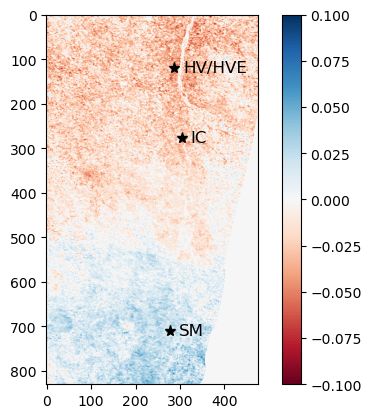

In [64]:
#The fieldsites of Happy Valley and Happy Valley East are too close to plot separately in this step.
labelpoints = [[119, 287], [277, 304], [710, 277]]
labelpointnames = ['HV/HVE','IC','SM']

plt.figure()
plt.imshow(ts_rec.timeseries[-1]-ts_rec.timeseries[0],vmin=-0.10,vmax=0.10,cmap='RdBu')
plt.colorbar()
for k,name in enumerate(labelpointnames):
    pt = labelpoints[k]
    plt.plot(pt[1],pt[0],'*',markersize=8,color='k')
    plt.text(pt[1]+20,pt[0]+10,name,fontsize=12)


<a id='permafrost_insar_diff'></a>
## 4.3 Compute the InSAR difference in displacments between the points

In [65]:

#Retrieve InSAR displacment differences between points
locdisp = []
for k,name in enumerate(pointnames):
    ts_rec = sm.reconstruct(timeseries=ts,dates_r=fielddates[k])
    ipt,jpt = pointsubsetlocs[k]
    locdisp.append(ts_rec.timeseries[-1,ipt,jpt])


<a id='permafrost_observation_diff'></a>
## 4.4 Compute the InSAR difference in displacments between the points

We find the difference in observed displacement, and then find the double difference between observation and InSAR

In [ ]:
__,atrib = readfile.read(Path(mintpy_dir)/timeseries_filename) #note data could be large, and will soon be replaced with data
xst = float(atrib['X_STEP'])
yst = float(atrib['Y_STEP'])

# loclen = len(pointnames)
dispdiff = []
obsdiff = []
obserr = []
ddf = []
dist = []

locvec = locdisp
loclen = len(locdisp)

for k in range(loclen):
    iref,jref = pointsubsetlocs[k]
    for l in range(k+1,loclen):    
        ipt,jpt = pointsubsetlocs[l]
        # locdisp2 = ts_rec.timeseries[-1,ipt,jpt]
        # locdiff = locdisp1-locdisp2
        dispdiff.append(locvec[k]-locvec[l]) #insar displacement difference
        obsdiff.append(obsdisp[k]-obsdisp[l])
        obserr.append(np.sqrt(obsstd[k]**2+obsstd[l]**2))
        ddf.append(np.abs(np.abs(dispdiff[-1])-np.abs(obsdiff[-1])))
        dist.append(np.sqrt(((iref-ipt)*yst)**2+((jref-jpt)*xst)**2)/1e3)

In [81]:
obsstd

0    0.020799
1    0.024090
2    0.026043
3    0.012270
Name: stdev, dtype: float64

<a id='permafrost_field_evaluate'></a> 
## 4.5 Evaluate displacements to NISAR permafrost requirement

Step 1: identify distances between field sites.

In [70]:
#DO NOT RUN
#Identify distances
__,atrib = readfile.read(Path(mintpy_dir)/timeseries_filename) 
xst = float(atrib['X_STEP'])
yst = float(atrib['Y_STEP'])

loclen = len(pointnames)
dist = np.zeros((loclen,loclen)) #distance, will be in km
for k in range(loclen):
    iref,jref = pointlocs[k]
    for l in range(loclen):
        ipt,jpt = pointlocs[l]
        dist[k,l] = np.sqrt(((iref-ipt)*yst)**2+((jref-jpt)*xst)**2)/1e3


Step 2: Compare the relative displacements to the requirement.

In [ ]:
ddf = np.array(ddf)*100               #double difference in cm
obserr = np.array(obserr)*100         #observation error in cm
dist = np.array(dist)                 #distance (in km)
reqvec = 4*(1+np.sqrt(dist))/10    #requirement in cm

# print(dist)
#remove HVE in 2023
sitemask = np.array([1,1,1,1,1,1],dtype='bool')
if year == 2023:
    sitemask = np.array([0, 1, 1, 0, 0, 1],dtype='bool')
if year == 2024:
    sitemask = np.array([1, 1, 0, 1, 0, 0],dtype='bool')
ddf = ddf[sitemask]
obserr = obserr[sitemask]
dist = dist[sitemask]
reqvec = reqvec[sitemask]

succvec = np.array(ddf <= reqvec)
succerr = np.array(ddf-obserr <= reqvec)
req_met_rate = np.sum(succvec)/len(succvec)
req_within_error_rate = np.sum(succerr)/len(succerr)

In [97]:
ddf

array([1.08826021, 1.67360775, 2.89427372, 0.58534754, 4.66516384,
       0.46818231])

Step 3: Evaluate and visualize comparison

Percent of double differences which meet the requirement: 66.7%
Percent of double differences within margin of error of requirement: 100.0%


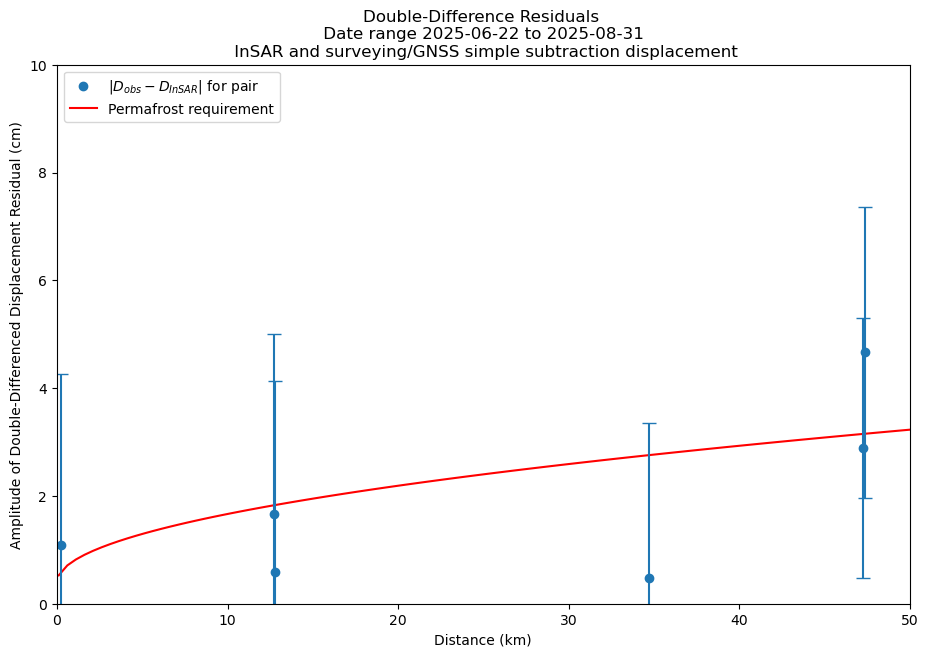

In [93]:
print(f"Percent of double differences which meet the requirement: {req_met_rate*100:.1f}%")
print(f"Percent of double differences within margin of error of requirement: {req_within_error_rate*100:.1f}%")

dist_th = np.linspace(0.1,50,100)  # distances for evaluation
acpt_error = 4*(1+np.sqrt(dist_th))  # permafrost threshold in mm
acpt_error_cm = acpt_error/10.
start_date = fielddates[0][0]
end_date = fielddates[0][1]

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(dist,ddf,label='|$D_{obs} - D_{InSAR}|$ for pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Permafrost requirement')
# ax.set_xscale('log')
plt.ylim(0,10)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} \n InSAR and surveying/GNSS simple subtraction displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.errorbar(dist,ddf,yerr=obserr,ls='none',capsize=5)
plt.show()

In [80]:
print(locvec)
print(obsdisp)

[-0.03935684802861239, -0.0427699976023692, -0.0188583522538925, 0.014599941435965083]
0   -0.034877
1   -0.020582
2   -0.038640
3   -0.009863
Name: rel_change, dtype: float64


In [ ]:
req_dist_fcn = True
reqval = 4
pair_req_met = np.array(pair_difference < reqval*(1+float(req_dist_fcn)*np.sqrt(pair_distance)))
pair_req_met[np.isnan(pair_difference)]=np.nan
df = pd.DataFrame(np.vstack([pair_distance,
                            pair_difference,
                            pair_req_met]).T,
                            columns=['distance', 'double_diff','req_met'])
# df['req'] = df['double_diff'][:] < requirement*(1+float(True)*np.sqrt(df['distance'][:]))

# remove nans
df_nonan = df.dropna(subset=['double_diff'])
bins = np.linspace(*permafrost_distance_rqmt, num=n_bins+1)
bin_centers = (bins[:-1] + bins[1:]) / 2
binned_df = df_nonan.groupby(pd.cut(df_nonan['distance'], bins),
                            observed=False)[['req_met']]

# get binned validation table 
bin_req = reqval*(1+float(req_dist_fcn)*np.sqrt(bin_centers))
validation = pd.DataFrame([])
validation['total_count[#]'] = binned_df.apply(lambda x: np.ma.masked_invalid(x).count())
validation['passed_req.[#]'] = binned_df.apply(lambda x: np.count_nonzero(x))

# Add total at the end
validation = pd.concat([validation, pd.DataFrame(validation.sum(axis=0)).T])
validation['passed_pc'] = validation['passed_req.[#]'] / validation['total_count[#]']
validation['success_fail'] = validation['passed_pc'] > threshold
validation.index.name = 'distance[km]'
# Rename last row
validation.rename({validation.iloc[-1].name:'Total'}, inplace=True)

In [142]:
# validation
req_thresh = 0.8

# distvec = np.concat([d
count = np.array([np.size(i) for i in ddf])
passed = np.array([np.sum(i) for i in succvec])
passed_within_MOE = np.array([np.sum(i) for i in succerr])
success = passed/count >= req_thresh
success_within_MOE = within_MOE/count >= req_thresh
# print(success)
# print(success_within_MOE)

validation = pd.DataFrame(np.vstack([dist,
                                   count,
                                   passed,
                                   passed_within_MOE,
                                   success,
                                   success_within_MOE],dtype=object).T,
                                   columns = ['distance[km]', 'count', 'passed', 'within_MOE', 'success', 'success_within_MOE'])

summrow = ['Total',
           np.sum(count),
           np.sum(passed),
           np.sum(within_MOE),
           np.sum(passed)/np.sum(count) >= req_thresh,
           np.sum(passed_within_MOE)/np.sum(count) >= req_thresh]
# validation = pd.concat([validation, pd.DataFrame(validation.sum(axis=0)).T])
# validation['passed_pc'] = validation['passed_req.[#]'] / validation['total_count[#]']
# validation['success_fail'] = validation['passed_pc'] > threshold
# validation.index.name = 'distance[km]'
# Rename last row
# validation.rename({validation.iloc[-1].name:'Total'}, inplace=True)

# print(validation)test

SyntaxError: '[' was never closed (3381000234.py, line 4)

In [134]:
pd.DataFrame(validation.sum(axis=0)).T

,distance[km],count,passed,within_MOE,success,success_within_MOE
0,310.201226,12,8,12,8,12


In [141]:
# np.array(np.append(dist,'Total'),dtype=object)

array(['0.25298221281347033', '12.712954023357435', '47.286767705141365',
       '12.769212974964432', '47.37141754264907', '34.70727877549607',
       'Total'], dtype=object)

In [ ]:
# df = pd.DataFrame(np.vstack([pair_distance,
#                             pair_difference,
#                             pair_req_met]).T,
#                             columns=['distance', 'double_diff','req_met'])

In [ ]:
validation = pd.DataFrame(columns = 'total

In [100]:
pair_req_met

NameError: name 'pair_req_met' is not defined

In [ ]:
#SAVE A REPROT

### Save the report

In [ ]:
# Save Method 2 results to file
run_date = dt.now().strftime('%Y%m%dT%H%M%S')
save_fldr = f"{run_date}-Permafrost-Method2"
# save_dir = os.path.join(mintpy_dir, save_fldr)
save_dir = Path.home()/'stash'

validation_fig_method2 = fig
validation_table_method2 = validation

save_params = {
    'save_dir': save_dir,
    'run_date': run_date,
    'requirement': "Permafrost",
    'site': site,
    'method': "2",
    'sitedata': sitedata,
    'gnss_insar_figs': [],
    'validation_figs': [validation_fig_method2],
    'validation_table': validation_table_method2,
    'ts_functions': None,
}
save_results(**save_params)

<a id='permafrost_insar_validate'></a>
# 5. Validation Method 2: InSAR-only structure fucntions

The NISAR permafrost validation requirement states that at least 80% of the time, the difference in surface displacement for two given points over 90 days should be no greater than $4(1+\sqrt{\text{L}})$ mm for points of L km apart, with $\text{L} \leq 50$ km.

The surface deformation across tundra permafrost will vary spatially due to multiple mechanisms, including soil type, excess surface ice, and local topography and climate. Variability occurs at spatial scales from centimeters to tens of kilometers. Nonetheless, we will evaluate the differences in surface displacement relative to the validation requirement using the InSAR signal alone over this terrain.

In [51]:
#Permafrost requirements:
dist_th = np.linspace(0.1,50,100)  # distances for evaluation (km)
acpt_error = 4*(1+np.sqrt(dist_th))  # permafrost threshold in mm, for dist in km
acpt_error_cm = acpt_error/10.  #cm

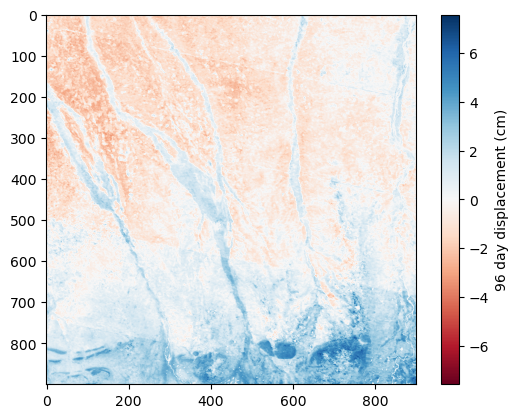

In [53]:
#show displacements at end of the timeseries
if 'timeseries_filename' not in locals():
    timeseries_filename = 'timeseries.h5'

with h5py.File(Path(mintpy_dir)/timeseries_filename, 'r') as f:
    dispmap = np.array(f['timeseries'][-1])*100

vmax = np.nanmax(np.abs(dispmap))
plt.figure()
plt.imshow(dispmap,vmin=-vmax,vmax=vmax,cmap='RdBu')
plt.colorbar(label='96 day displacement (cm)')

<a id='permafrost_insar_structure'></a>
##  5.1 Use structure functions to identify pixel pairs

We sample a large set of pixel pairs to compare relative displacements with. We use a water mask from the Hyp3 processing to mask out locations to not use. Information about how that water mask is developed can [be found here](https://storymaps.arcgis.com/stories/485916be1b1d46889aa436794b5633cb).

/home/jovyan/forks/ATBD/methods/permafrost/solid_utils/sampling.py:223: UserWarning: Using all data points: 801125
  warnings.warn(f'Using all data points: {n_points}')


Text(0, 0.5, 'Frequency')

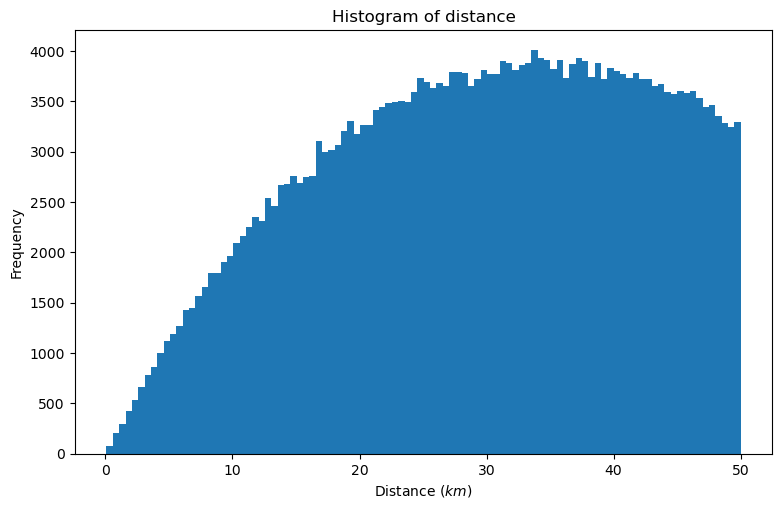

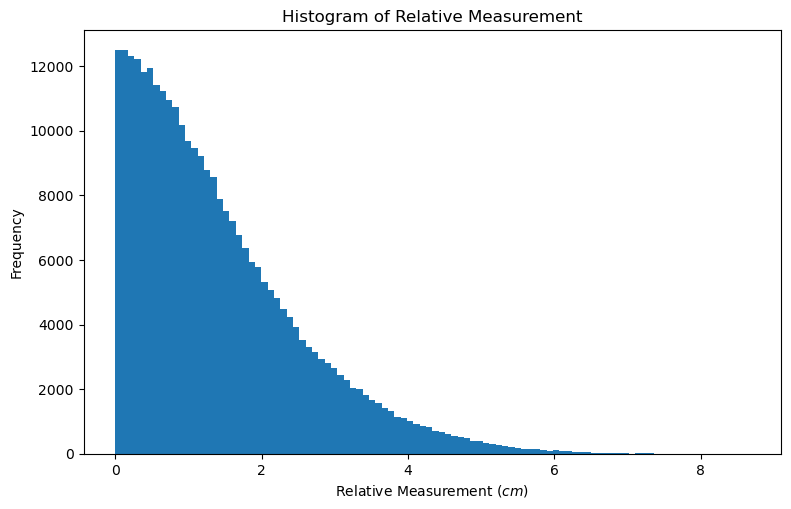

In [54]:
__,atrib = readfile.read(Path(mintpy_dir)/timeseries_filename)

X0,Y0 = load_geo_utm(atrib)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

M2dist = []; rel_measure = []

tsmap = dispmap
tsmap[tsmap==0]=np.nan

# wmask = pu.get_watermask(Path(gunw_dir))
with h5py.File(Path(mintpy_dir)/'waterMask.h5') as data:
    wmask = data['waterMask'][:]
tsmap[wmask==0]=np.nan

#deramping will remove linear spatial trends in the displacement data, currently disabled
dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,tsmap,num_samples=1000000,deramp=False)

M2dist.append(dist_i)             #distance of pair, in m
rel_measure.append(rel_measure_i) #relative displacement of pair, in cm 
    
M2dist,rel_measure = np.array(M2dist),np.array(rel_measure)

#use only pixel pairs within 50 km
rel_measure = rel_measure[M2dist<=50e3]
M2dist=M2dist[M2dist<=50e3]

M2km = [i/1e3 for i in M2dist]  #convert distance to km
rmcm = [i for i in rel_measure] #relative measure in cm

fig, ax = plt.subplots(figsize=[9, 5.5])
img1 = ax.hist(M2km, bins=100)
ax.set_title(f"Histogram of distance")
ax.set_xlabel(r'Distance ($km$)')
ax.set_ylabel('Frequency')

fig, ax = plt.subplots(figsize=[9, 5.5])
img1 = ax.hist(rmcm, bins=100)
ax.set_title(f"Histogram of Relative Measurement")
ax.set_xlabel(r'Relative Measurement ($cm$)')
ax.set_ylabel('Frequency')

In [55]:
start_date = dt.strptime(atrib['START_DATE'], '%Y%m%d')
end_date = dt.strptime(atrib['END_DATE'], '%Y%m%d')
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

# Define requirement
permafrost_threshold_rqmt = 4  # mm/yr
permafrost_distance_rqmt = [0.1, 50.0]  # km

# Validation parameters
n_bins = 10
# threshold = 0.683  
threshold = 0.8

pair_distance = np.array([i/1e3 for i in dist_i])
pair_difference = np.array([i*10 for i in rel_measure_i])

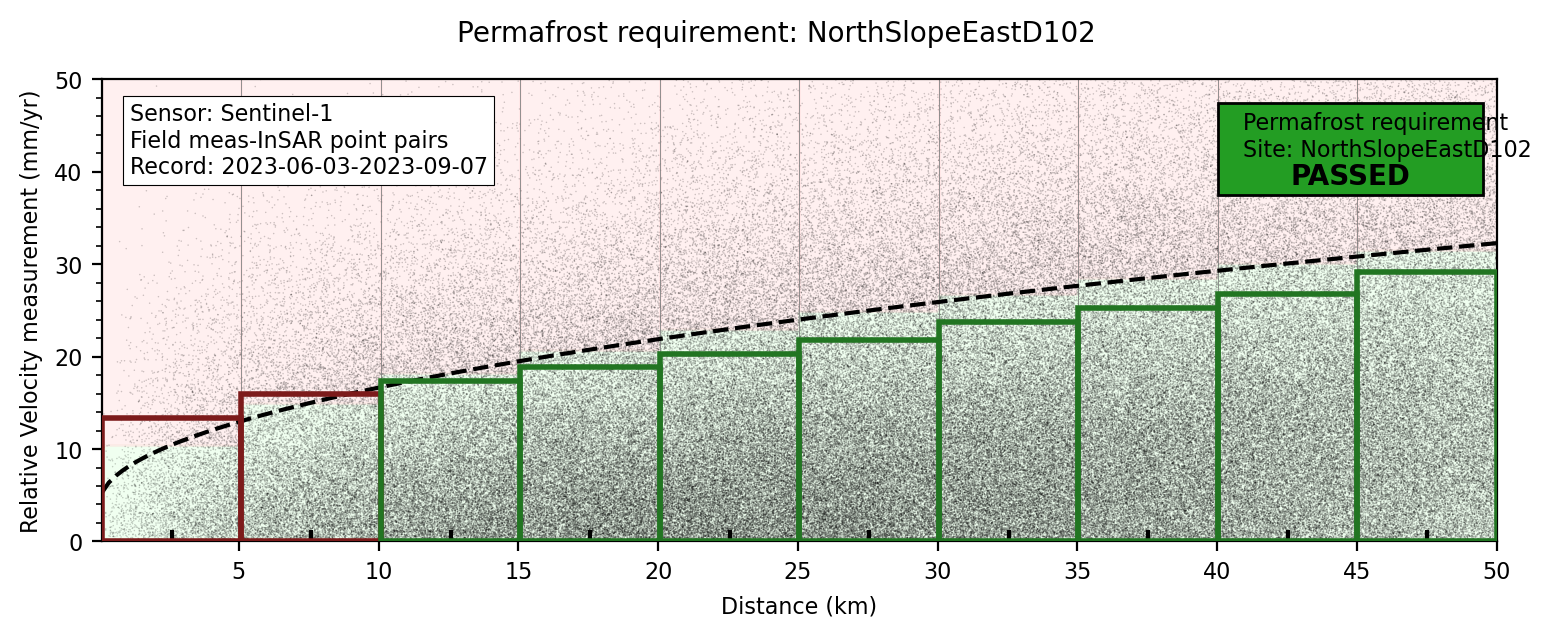

In [57]:
validation_table,fig = display_permafrost_validation(pair_distance,          # binned distance for point
                        pair_difference,              # binned relative velocities mm/yr
                        site,                         # calval site
                        start_str,                   #
                        end_str,
                        requirement=permafrost_threshold_rqmt,
                        req_dist_fcn=True,
                        distance_rqmt = permafrost_distance_rqmt,  # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                        n_bins=n_bins,                  # number of bins, to collect statistics 
                        threshold=threshold,            # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                        sensor='Sentinel-1',            # sensor that is validated, Sentinel-1 or NISAR
                        validation_type='permafrost',
                        validation_data='Field meas')        # validation method: GNSS - Method 1, InSAR - Method 2

In [65]:
req_dist_fcn = True
reqval = 4
pair_req_met = np.array(pair_difference < reqval*(1+float(req_dist_fcn)*np.sqrt(pair_distance)))
pair_req_met[np.isnan(pair_difference)]=np.nan
df = pd.DataFrame(np.vstack([pair_distance,
                            pair_difference,
                            pair_req_met]).T,
                            columns=['distance', 'double_diff','req_met'])
# df['req'] = df['double_diff'][:] < requirement*(1+float(True)*np.sqrt(df['distance'][:]))

# remove nans
df_nonan = df.dropna(subset=['double_diff'])
bins = np.linspace(*permafrost_distance_rqmt, num=n_bins+1)
bin_centers = (bins[:-1] + bins[1:]) / 2
binned_df = df_nonan.groupby(pd.cut(df_nonan['distance'], bins),
                            observed=False)[['req_met']]

# get binned validation table 
bin_req = reqval*(1+float(req_dist_fcn)*np.sqrt(bin_centers))
validation = pd.DataFrame([])
validation['total_count[#]'] = binned_df.apply(lambda x: np.ma.masked_invalid(x).count())
validation['passed_req.[#]'] = binned_df.apply(lambda x: np.count_nonzero(x))

# Add total at the end
validation = pd.concat([validation, pd.DataFrame(validation.sum(axis=0)).T])
validation['passed_pc'] = validation['passed_req.[#]'] / validation['total_count[#]']
validation['success_fail'] = validation['passed_pc'] > threshold
validation.index.name = 'distance[km]'
# Rename last row
validation.rename({validation.iloc[-1].name:'Total'}, inplace=True)

In [67]:
validation

,total_count[#],passed_req.[#],passed_pc,success_fail
distance[km],,,,
"(0.1, 5.09]",5998,4402,0.733911,False
"(5.09, 10.08]",16033,12500,0.779642,False
"(10.08, 15.07]",24318,19912,0.818817,True
"(15.07, 20.06]",30053,25271,0.840881,True
"(20.06, 25.05]",34745,29498,0.848985,True
"(25.05, 30.04]",37193,31702,0.852365,True
"(30.04, 35.03]",38723,32851,0.848359,True
"(35.03, 40.02]",38352,32530,0.848196,True
"(40.02, 45.01]",37029,31379,0.847417,True


In [68]:
from solid_utils.saving import save_results

In [70]:
# Save Method 2 results to file
run_date = dt.now().strftime('%Y%m%dT%H%M%S')
save_fldr = f"{run_date}-Permafrost-Method2"
save_dir = os.path.join(mintpy_dir, save_fldr)

validation_fig_method2 = fig
validation_table_method2 = validation

save_params = {
    'save_dir': save_dir,
    'run_date': run_date,
    'requirement': "Permafrost",
    'site': site,
    'method': "2",
    'sitedata': sitedata,
    'gnss_insar_figs': [],
    'validation_figs': [validation_fig_method2],
    'validation_table': validation_table_method2,
    'ts_functions': None,
}
save_results(**save_params)

Creating 20250820T002042-Permafrost-Method2
Saving validation figure to: Permafrost_Method2_validation_figure1.png
Saved parameters and results to: /home/jovyan/NISAR_cal_data/Hyp3_S1/permafrost/NorthSlopeEastD102/2023/MintPy/20250820T002042-Permafrost-Method2


In [71]:
mintpy_dir

'/home/jovyan/NISAR_cal_data/Hyp3_S1/permafrost/NorthSlopeEastD102/2023/MintPy'

<a id='permafrost_insar_evaluate'></a>
## 5.3 OLD Compare pair displacements to requirement

In [22]:
#Here we define a function to help with the plotting in this section.

from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def arraypercentile(arr,p,axis=0,bounds=None):
    """for a given array arr, returns the index of where that percentile
    is reached."""
    
    if axis==0:
        arr= np.transpose(arr)
    
    ilen,jlen = np.shape(arr)

    if bounds==None:
        bounds=[0,ilen]
    boundlen = bounds[1]-bounds[0]
    targets = np.sum(arr,axis=0)*p
    perindex = np.zeros(jlen)
    pervals = np.zeros(jlen)
    
    for j in range(jlen):
        currsum = 0
        curri = -1
        jtarget = targets[j]
        while currsum<=jtarget:
            oldsum=currsum
            curri += 1
            currsum += arr[curri,j]

        overfrac = (jtarget-oldsum)/(currsum-oldsum)
        perindex[j] = (curri-1)+overfrac
        pervals[j]=bounds[0]+perindex[j]/ilen*(boundlen)
    return pervals

Requirement success rate: 83.8%


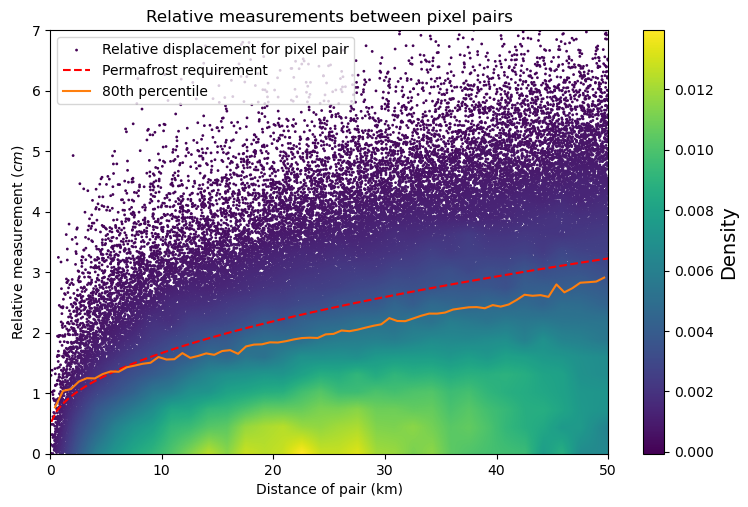

In [23]:
#requirements in mm (needs M2dist in km):
rel_req = 4*(1+np.sqrt(M2dist/1e3)) / 10 #req in cm

n_samples = len(M2dist)
n_met = np.sum(rel_measure<=rel_req)

print(f'Requirement success rate: {n_met/n_samples*100:.1f}%')
      
# Color plotted points by density. This is what interpn from scipy is required for.
# Code inspired by https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
x,y = np.array(M2km), np.array(rmcm)
nbins = 30
data , x_e, y_e = np.histogram2d(x,y, bins=(nbins,nbins), density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T,
                method = "linear",fill_value=None, bounds_error = False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=[9, 5.5])
ax.scatter( x, y, c=z,s=1,label='Relative displacement for pixel pair')

ax.set_xlim(0,50)
ax.set_ylim(0,7)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('Density',fontsize=14)
ax.plot(dist_th, acpt_error_cm, '--', color='r',label='Permafrost requirement')

#go through data again to make 80th percentile line
nbins = 70
data , x_e, y_e = np.histogram2d(x,y, bins=(nbins,nbins), density = True )
pervec = arraypercentile(data,.8,bounds=[y_e[0],y_e[-1]])
xmid = [.5*(x_e[i]+x_e[i+1]) for i in range(len(x_e)-1)]
ax.plot(xmid,pervec,color='C01',label='80th percentile')

ax.set_title(f"Relative measurements between pixel pairs")
ax.set_ylabel(r'Relative measurement ($cm$)')
ax.set_xlabel('Distance of pair (km)')

plt.legend(loc='upper left')

out_fig = os.path.abspath('permafrost_insar_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

### Save Method 1 or 2 results to file

In [ ]:
run_date = dt.now().strftime('%Y%m%dT%H%M%S')
save_fldr = f"{run_date}-Permafrost-Method2"
save_dir = os.path.join(mintpy_dir, save_fldr)

In [10]:
#site
#ok my sitedata is a little bit different

'NorthSlopeEastD102'

In [5]:
# Save Method 2 results to file
run_date = dt.now().strftime('%Y%m%dT%H%M%S')
save_fldr = f"{run_date}-Permafrost-Method2"
save_dir = os.path.join(mintpy_dir, save_fldr)

save_params = {
    'save_dir': save_dir,
    'run_date': run_date,
    'requirement': "Permafrost",
    'site': site,
    'method': "2",
    'sitedata': sitedata,
    'gnss_insar_figs': [gnss_insar_fig],
    'validation_figs': [validation_fig_method2],
    'validation_table': validation_table_method2,
    'ts_functions': ts_functions,
}
# save_results(**save_params)

NameError: name 'gnss_insar_fig' is not defined

In [7]:
save_results()
#'sitedata': sitedata['sites'][site]

NameError: name 'save_results' is not defined

<a id='permafrost_references'></a>
### References

Zwieback, Simon, and Franz J. Meyer. "Top-of-permafrost ground ice indicated by remotely sensed late-season subsidence." *The Cryosphere* 15 (2021): 2041-2055.